# Sparse regression based model discovery
### hard case from PDE-STRIDE paper: Burgers equation

In [1]:
import numpy as np
import matplotlib.pylab as plt

from sparsity_estimators import Adaptive_Lasso_SS, ir_cond,ir_condAL

from sklearn.utils.random import sample_without_replacement
from sklearn.utils import resample, shuffle
from sklearn.linear_model import Ridge

from scipy.stats import beta

from matplotlib import rc, font_manager
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style("white")

from time import time

# Adaptive Lasso with stability selection and error control

In [2]:
def adaLasso(X,y,magnitude='LS', super_power=2, B=20, EVmax=3, randomized=False, n_alphas=10, eps=3):

    theta_ = np.array(X,dtype=np.float64)
    dt_ = np.array(y,dtype=np.float64)
    normed_dt = dt_/np.linalg.norm(dt_,axis=0,keepdims=True)
    normed_theta = theta_/np.linalg.norm(theta_,axis=0,keepdims=True)

    t_start = time()
    mask, for_plots= Adaptive_Lasso_SS(normed_theta,normed_dt,
                                       nI = B,
                                       super_power=super_power,
                                       efp=EVmax,
                                       randomized=randomized,n_alphas=n_alphas,
                                       eps=eps)
    t_end = time()
    print('computational cost:', t_end - t_start)

    if magnitude == 'LS':
        coeffs = np.linalg.lstsq(theta_*mask,dt_,rcond=None)[0]
    
    if magnitude == 'Ridge':
        clf = Ridge(alpha=1e-8,fit_intercept=False)
        coeffs = clf.fit(theta_*mask, dt_).coef_

    return coeffs,for_plots

# Loading noisy Burgers data

In [3]:
theta = np.array(np.load('data/theta_IHT_burgers.npy'),dtype=np.float32)
dt    = np.array(np.load('data/dt_IHT_burgers.npy'),dtype=np.float32)
lib_des    = np.load('data/lib_description_IHT_burgers.npy')

<ipython-input-3-9fcd083d3ffe>:1: ComplexWarning: Casting complex values to real discards the imaginary part
  theta = np.array(np.load('data/theta_IHT_burgers.npy'),dtype=np.float32)
<ipython-input-3-9fcd083d3ffe>:2: ComplexWarning: Casting complex values to real discards the imaginary part
  dt    = np.array(np.load('data/dt_IHT_burgers.npy'),dtype=np.float32)


In [4]:
theta, dt = shuffle(theta, dt, random_state=0)

In [5]:
# ground truth indices in the library
GT = [5,8]

# Stability selection with error control

In [6]:
idx = sample_without_replacement(n_population=theta.shape[0]-1, n_samples=1000, random_state=42)

X = theta[idx,1:] # here we start at 1 like PDE-STRIDE
y = dt[idx]

xi, for_plots = adaLasso(X,y,magnitude='LS',B=250, super_power=1, n_alphas=20, eps=4, randomized=True)

[tau,piT,pSE,alphas, minLambdaSS, active_set,region] = for_plots

computational cost: 1.2911436557769775


Text(0.5, 1.0, 'Randomized Adaptive Lasso')

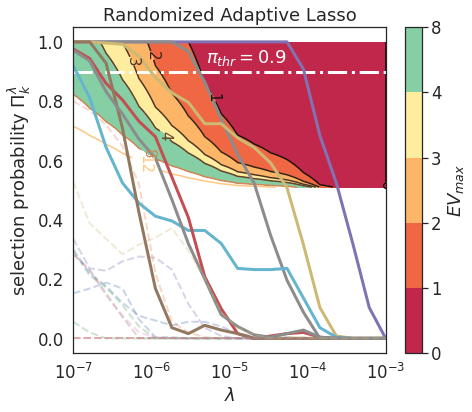

In [7]:
fig,ax = plt.subplots(1,1,figsize=(7,6))

    
piT = 0.9
efp=8
# average of selected variables
q_hat = tau.sum(axis=1)
# verifying on some upper bound on efp
ev_region = (q_hat)**2/((2*piT-1)*X.shape[1])    
idxS = (ev_region<efp).argmax()   
minLambdaSS = alphas[idxS]
# selecting variables where the efp is respected
active_set = (tau[idxS:,:]>piT).any(axis=0)   

thrs = np.arange(0.51,1,0.001)

E_V_ub = np.stack([(q_hat)**2/((2*piT-1)*X.shape[1]) for piT in thrs])

c=ax.contour(alphas, thrs, E_V_ub,levels=[0,1,2,3,4,8,12],cmap='copper')
cf=ax.contourf(alphas, thrs, E_V_ub,levels=[0,1,2,3,4,8],cmap='Spectral')
ax.clabel(c, inline=True,fmt='%0.0f', fontsize=15)

ax.plot([alphas.min(),alphas.max()],[0.9,0.9],'-.',color='white',linewidth=3)
ax.text(5e-6,0.93,r'$\pi_{thr}=0.9$',color='white')

d=fig.colorbar(cf, ax=ax)
d.set_label(r'$EV_{max}$')

ax.set_xlabel(r'$\lambda$')#, fontsize=font_size)
ax.set_ylabel(r'selection probability $\Pi_{k}^{\lambda}$')


for term in range(X.shape[1]): # here 36 is the number of terms in the library
    if active_set[term]:
        al=1
        ls='-'
        lw=3
    else:
        al=0.3
        ls='--'
        lw=2   
    ax.plot(alphas,tau[:,term],linestyle=ls,alpha=al,linewidth=lw)
    ax.set_xscale('log')

ax.set_title('Randomized Adaptive Lasso')




### Tuning EVmax allows to recover GT

In [8]:
EVmax = 2

# average of selected variables
q_hat = tau.sum(axis=1)
# verifying on some upper bound on efp
ev_region = (q_hat)**2/((2*piT-1)*X.shape[1])    
idxS = (ev_region<EVmax).argmax()   
minLambdaSS = alphas[idxS]
# selecting variables where the efp is respected
active_set = (tau[idxS:,:]>piT).any(axis=0)   

np.where(active_set)[0]+1  #+1 to match PDE-STRIDE definition

array([5, 8])

In [9]:
lib_des[np.where(active_set)[0]+1]

array(['uu_{x}', 'u_{xx}'], dtype='<U11')

In [10]:
GT

[5, 8]